# GeoPandas Tutorial

## Summary

This notebook contains a basic tutorial for getting started with GeoPandas using some basic methods in GeoPandas and the underlying Shapely python libraries.

## Contents

Sections of this tutorial include:

1. **Download data sources required for the tutorial**

2. **Read in dataframes required for the tutorial**

3. **Make some basic plots using GeoPandas and matplotlib**

4. **Generate a basic choropleth density plot using GeoPandas and matplotlib**

5. **Match coordinates in one dataframe to corresponding shapes in a separate shapefile**

6. **Find the minimum and maximum coordinate bounds to each polygon in a shapefile**


## Import required libraries and set 'root' variables for read/write paths 

In [1]:
import urllib
import os
import pathlib
import requests
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, MultiPoint
%matplotlib inline

In [2]:
# set data root for all relative paths
DATA_ROOT = './data/'
FIGURES_ROOT = './figures/'

## 1. Download data sources required for this tutorial

In [3]:
# create list of URLs for data download locations
url_list = [
    'http://bostonopendata-boston.opendata.arcgis.com/datasets/b6bffcace320448d96bb84eabb8a075f_0.csv',
    'https://data.boston.gov/dataset/e02c44d2-3c64-459c-8fe2-e1ce5f38a035/resource/695a8596-5458-442b'\
    '-a017-7cd72471aade/download/fy19fullpropassess.csv',
    'http://bostonopendata-boston.opendata.arcgis.com/datasets/53ea466a189b4f43b3dfb7b38fa7f3b6_1.zip'
]

# create list of filenames (without extensions) for renaming direct URL files
name_list = ['SAMaddresses', 'FY19_propassessments', 'ZIPshapefiles']

# generate lists for original filenames, new filenames, and target new filepaths
orig_filename_list = [os.path.basename(url) for url in url_list]
filename_list = [
    ''.join([name, os.path.splitext(orig_filename)[1]]) for name, orig_filename in zip(
        name_list,
        orig_filename_list
    )
]
filepath_list = [
    os.path.join(DATA_ROOT, filename) for filename in filename_list
]

# report on lists
print(orig_filename_list)
print(filename_list)
print(filepath_list)

['b6bffcace320448d96bb84eabb8a075f_0.csv', 'fy19fullpropassess.csv', '53ea466a189b4f43b3dfb7b38fa7f3b6_1.zip']
['SAMaddresses.csv', 'FY19_propassessments.csv', 'ZIPshapefiles.zip']
['./data/SAMaddresses.csv', './data/FY19_propassessments.csv', './data/ZIPshapefiles.zip']


In [4]:
# create list of current top-level files and directories
directories = os.listdir('.')

# check for ./data/ dir and create if it doesn't exist
if not os.path.dirname(DATA_ROOT)[2:] in directories:
    os.mkdir(DATA_ROOT)

# also check for ./figures/ dir and create if it doesn't exist
if not os.path.dirname(FIGURES_ROOT)[2:] in directories:
    os.mkdir(FIGURES_ROOT)

# create list of files currently present in DATA_ROOT
files = os.listdir(DATA_ROOT)

# download data files if they do not already exist
for filepath, filename, url in zip(filepath_list, filename_list, url_list):
    if not filename in files:
        local_filename, headers = urllib.request.urlretrieve(
            url,
            filepath
        )

# confirm list of new files in DATA_ROOT
files = os.listdir(DATA_ROOT)

# report on files
print(files)

['ZIP_Codes.shx', 'ZIP_Codes.prj', 'SAMaddresses.csv', 'ZIP_Codes.dbf', '.gitkeep', 'ZIPshapefiles.zip', 'ZIP_Codes.shp', 'FY19_propassessments.csv', 'ZIP_Codes.cpg']


### Unzip downloaded shapefiles archive

In [5]:
# load mc_enhance csv data directly from zip archive using zipfile
with zipfile.ZipFile(filepath_list[2], 'r') as zipobj:
    
    # report on contents of zip archive
    print("This zip archive contains the following files: {0}\n".format(zipobj.namelist()))
    
    # extract all files
    zipobj.extractall(DATA_ROOT)

# confirm extracted datafiles
files = os.listdir(DATA_ROOT)
print(files)

# save filepath for newly extracted .shp file
filepath_shape = os.path.join(DATA_ROOT, 'ZIP_Codes.shp') 

This zip archive contains the following files: ['ZIP_Codes.prj', 'ZIP_Codes.shp', 'ZIP_Codes.cpg', 'ZIP_Codes.shx', 'ZIP_Codes.dbf']

['ZIP_Codes.shx', 'ZIP_Codes.prj', 'SAMaddresses.csv', 'ZIP_Codes.dbf', '.gitkeep', 'ZIPshapefiles.zip', 'ZIP_Codes.shp', 'FY19_propassessments.csv', 'ZIP_Codes.cpg']


## 2. Read in dataframes required for the tutorial

In [6]:
# Read in SAM and property assessment dataframes from saved CSV files
df_sam = pd.read_csv(filepath_list[0], dtype=str)
df_prop = pd.read_csv(filepath_list[1], dtype=str)

# Convert 'X' and 'Y' (i.e. lat/lon) values in SAM dataframe to floats 
df_sam['X'] = df_sam['X'].astype(float)
df_sam['Y'] = df_sam['Y'].astype(float)

In [7]:
# set the filepath and load in a shapefile using Geopandas
gdf_zipshapes = gpd.read_file(filepath_shape)

# check data type so we can see that this is a "GEO" dataframe
# check shape and return head to see values
print(type(gdf_zipshapes))
print()
print(gdf_zipshapes.shape)
print()
gdf_zipshapes.head()

<class 'geopandas.geodataframe.GeoDataFrame'>

(43, 5)



,OBJECTID,ZIP5,ShapeSTAre,ShapeSTLen,geometry
0,1,02134,3.721936e+07,40794.182396,POLYGON ((-71.12340461235522 42.36420867214283...
1,2,02125,6.476052e+07,62224.521440,POLYGON ((-71.04541458491363 42.32380666715233...
2,3,02110,6.637284e+06,18358.213496,POLYGON ((-71.05109058896998 42.36418367507441...
3,4,02118,3.116158e+07,32353.407618,POLYGON ((-71.06315159137533 42.34688867055895...
4,5,02126,6.078585e+07,45488.394711,POLYGON ((-71.09669659978795 42.29095065982932...


## 3. Make some basic plots using GeoPandas and matplotlib

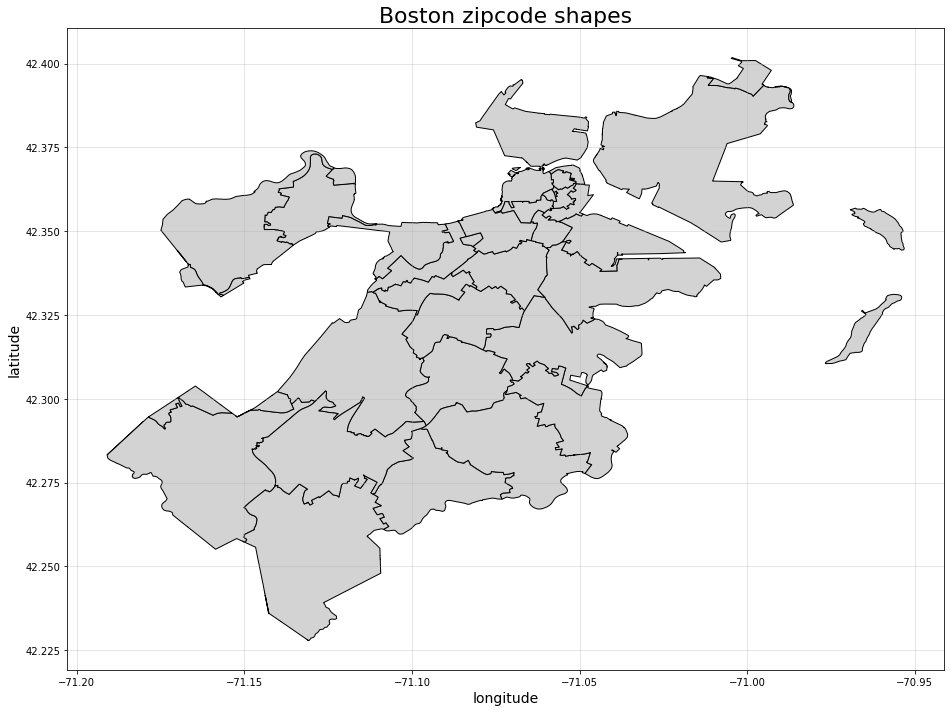

In [8]:
# plot basic shapefile polygons to lat/lon grid using Geopandas .plot() method
# coupled with basic matplotlib pyplot features/methods

fig, ax = plt.subplots(figsize=(16,10))
plt.title(
    'Boston zipcode shapes',
    fontsize=22
)

# note that the geopandas dataframe object, has a .plot() method for easy plotting
gdf_zipshapes.plot(ax=ax, color='lightgray', edgecolor='k')

plt.xlabel('longitude', fontsize=14)
plt.ylabel('latitude', fontsize=14)
plt.grid(":", alpha=0.4)
plt.tight_layout()
plt.show();

In [9]:
# To label each shape, we first need to find a "representative point" for each polygon geometry
# shapely (built into geopandas) can handle this with the representative_point() method

gdf_zipshapes['coords'] = gdf_zipshapes['geometry'].apply(lambda x: x.representative_point().coords[:])
gdf_zipshapes['coords'] = [coords[0] for coords in gdf_zipshapes['coords']]

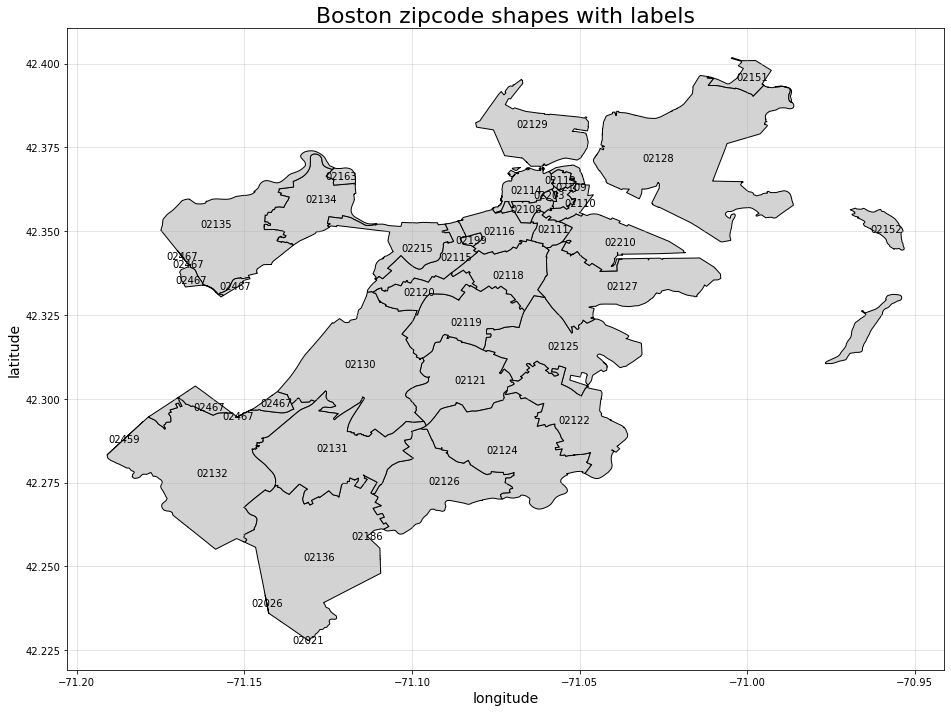

In [10]:
# and then using matplotlib's annotate() method, we can print zip5 values to our map

fig, ax = plt.subplots(figsize=(16,10))
plt.title(
    'Boston zipcode shapes with labels',
    fontsize=22
)

gdf_zipshapes.plot(ax=ax, color='lightgray', edgecolor='k')

# here we use the geopandas dataframe object's built-in iterrows() method
# to turn gdf_zipshapes into a generator object for iteration
for idx, row in gdf_zipshapes.iterrows():
    plt.annotate(
        s=row['ZIP5'],
        xy=row['coords'],
        horizontalalignment='center',
        verticalalignment='center'
    )

plt.xlabel('longitude', fontsize=14)
plt.ylabel('latitude', fontsize=14)
plt.grid(":", alpha=0.4)
plt.tight_layout()
plt.show();

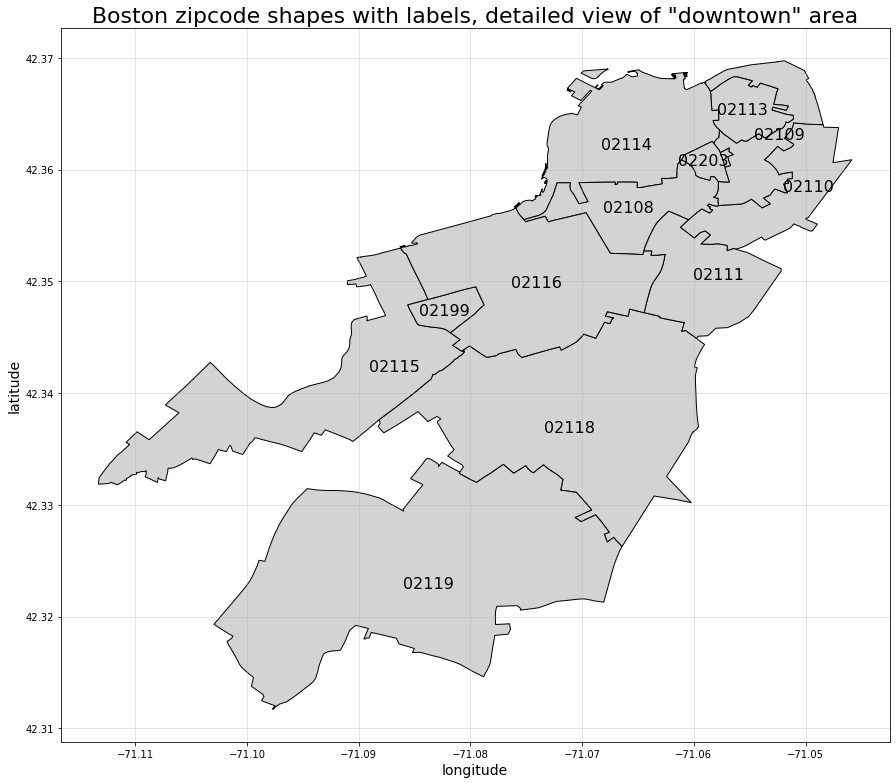

In [11]:
# and then using .loc[] we can subset our geopandas dataframe to plot only
# a subset of our zipcodes, perhaps to zoom in and make the downtown zipcodes easier to see

loc = (
    (gdf_zipshapes['ZIP5'].str.contains('0211')) |
    (gdf_zipshapes['ZIP5'].str.contains('0210')) |
    (gdf_zipshapes['ZIP5'] == '02199') |
    (gdf_zipshapes['ZIP5'] == '02203')
)

fig, ax = plt.subplots(figsize=(16,11))
plt.title(
    'Boston zipcode shapes with labels, detailed view of "downtown" area',
    fontsize=22
)

gdf_zipshapes.loc[loc].plot(ax=ax, color='lightgray', edgecolor='k')

for idx, row in gdf_zipshapes.loc[loc].iterrows():
    plt.annotate(
        s=row['ZIP5'],
        xy=row['coords'],
        horizontalalignment='center',
        verticalalignment='center',
        fontsize=16
    )

plt.xlabel('longitude', fontsize=14)
plt.ylabel('latitude', fontsize=14)
plt.grid(":", alpha=0.4)
plt.tight_layout()
plt.show();

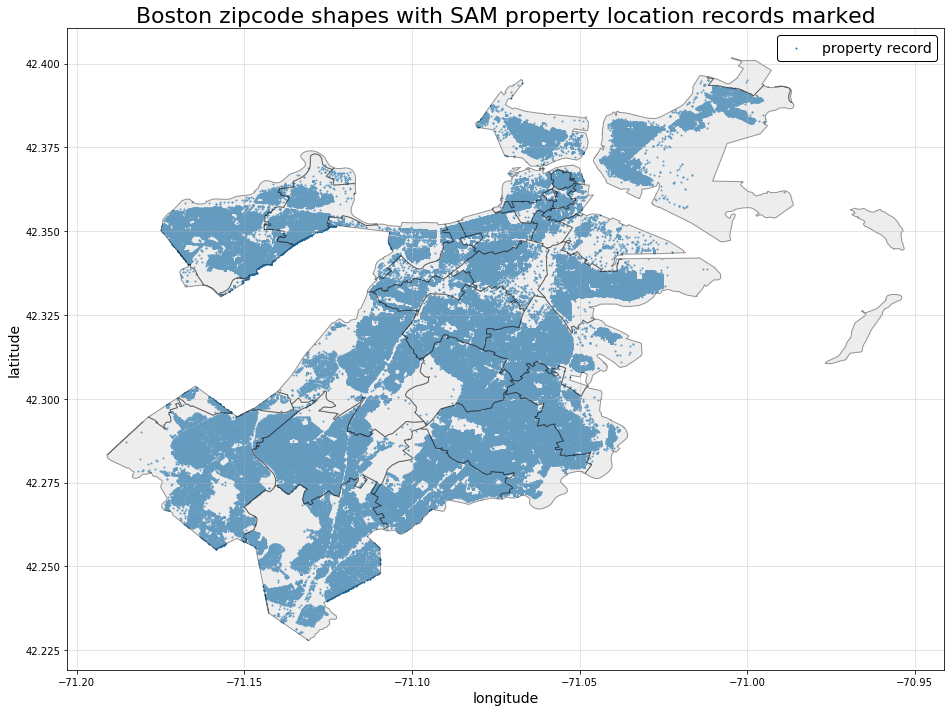

In [12]:
# using basic matplotlib plotting funtions, we can also layer our datapoints along with the shapes 
fig, ax = plt.subplots(figsize=(16,10))
plt.title(
    'Boston zipcode shapes with SAM property location records marked',
    fontsize=22
)

plt.scatter(df_sam['X'], df_sam['Y'], alpha=1, s=1, label='property record')

gdf_zipshapes.plot(ax=ax, color='lightgray', edgecolor='k', alpha=0.4)


plt.xlabel('longitude', fontsize=14)
plt.ylabel('latitude', fontsize=14)
plt.grid(":", alpha=0.4)
plt.legend(edgecolor='k', framealpha=1, fontsize=14)
plt.tight_layout()
plt.show();

## 4. Generate a basic choropleth density plot using GeoPandas

In [13]:
# now to create a summary table from the SAM addresses for visuallizing
# property records density by ZIP using our shapefile for aggregation

# first create summary count data by unique ZIP
prop_count_by_zip = df_sam.groupby('ZIP_CODE').agg(
    {'ZIP_CODE':'count'}
).rename({'ZIP_CODE': 'properties'}, axis=1)

print(prop_count_by_zip.shape)
prop_count_by_zip.head()

(37, 1)


,properties
ZIP_CODE,
02026,1
02108,4366
02109,4392
02110,3555
02111,6092


In [14]:
# Next we merge our count data with our shapefile polygon geometries dataframe
gdf_zip_prop = gdf_zipshapes.join(prop_count_by_zip, on='ZIP5')

print(gdf_zip_prop.shape)
print()
print(
    'Property-counts-per-zip summary stats\n{}'.format(
    gdf_zip_prop['properties'].describe()
    )
)
gdf_zip_prop.head()

(43, 7)

Property-counts-per-zip summary stats
count       38.000000
mean     10621.263158
std       8877.230179
min          1.000000
25%        921.000000
50%      11822.500000
75%      15472.000000
max      30071.000000
Name: properties, dtype: float64


,OBJECTID,ZIP5,ShapeSTAre,ShapeSTLen,geometry,coords,properties
0,1,02134,3.721936e+07,40794.182396,POLYGON ((-71.12340461235522 42.36420867214283...,"(-71.12704824441153, 42.35944218076044)",14644.0
1,2,02125,6.476052e+07,62224.521440,POLYGON ((-71.04541458491363 42.32380666715233...,"(-71.05487618131991, 42.31578366454911)",19400.0
2,3,02110,6.637284e+06,18358.213496,POLYGON ((-71.05109058896998 42.36418367507441...,"(-71.04976610342825, 42.35849650724344)",3555.0
3,4,02118,3.116158e+07,32353.407618,POLYGON ((-71.06315159137533 42.34688867055895...,"(-71.07117288285457, 42.33688916926195)",19608.0
4,5,02126,6.078585e+07,45488.394711,POLYGON ((-71.09669659978795 42.29095065982932...,"(-71.09036847374043, 42.275358656948306)",14376.0


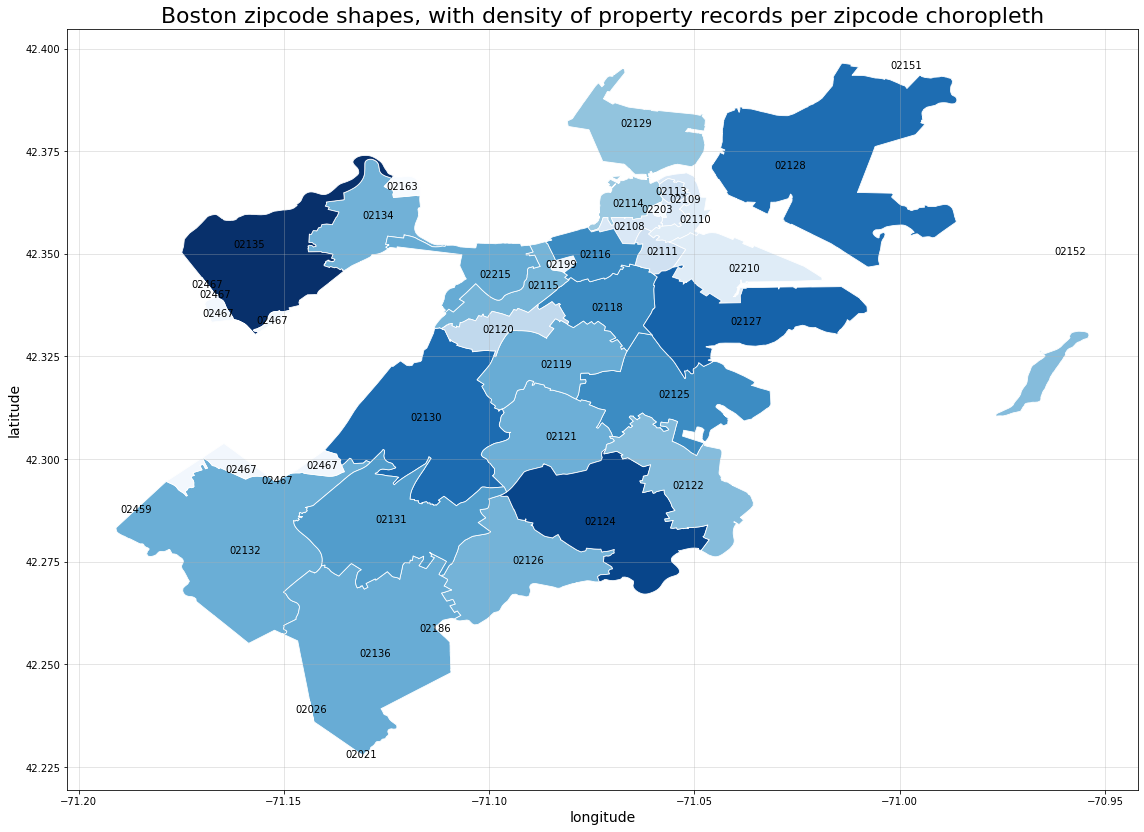

In [15]:
# identify the variable column name we're using
variable = 'properties'

# plot results
fig, ax = plt.subplots(figsize=(16,16))

plt.title(
    'Boston zipcode shapes, with density of property records per zipcode choropleth',
    fontsize=22
)

# NOTE: null values must be dropped from our df (as is shown below).
#       Otherwise, the choropleth does not provide any gradation in color
gdf_zip_prop.dropna(subset=[variable]).plot(
    column=variable,
    cmap='Blues',
    linewidth=0.8,
    ax=ax,
    edgecolor='white'
)

# here we use the geopandas dataframe object's built-in iterrows() method
# to turn gdf_zipshapes into a generator object for iteration
for idx, row in gdf_zipshapes.iterrows():
    plt.annotate(
        s=row['ZIP5'],
        xy=row['coords'],
        horizontalalignment='center',
        verticalalignment='center'
    )

plt.xlabel('longitude', fontsize=14)
plt.ylabel('latitude', fontsize=14)
plt.grid(":", alpha=0.4)
plt.tight_layout()
plt.show();

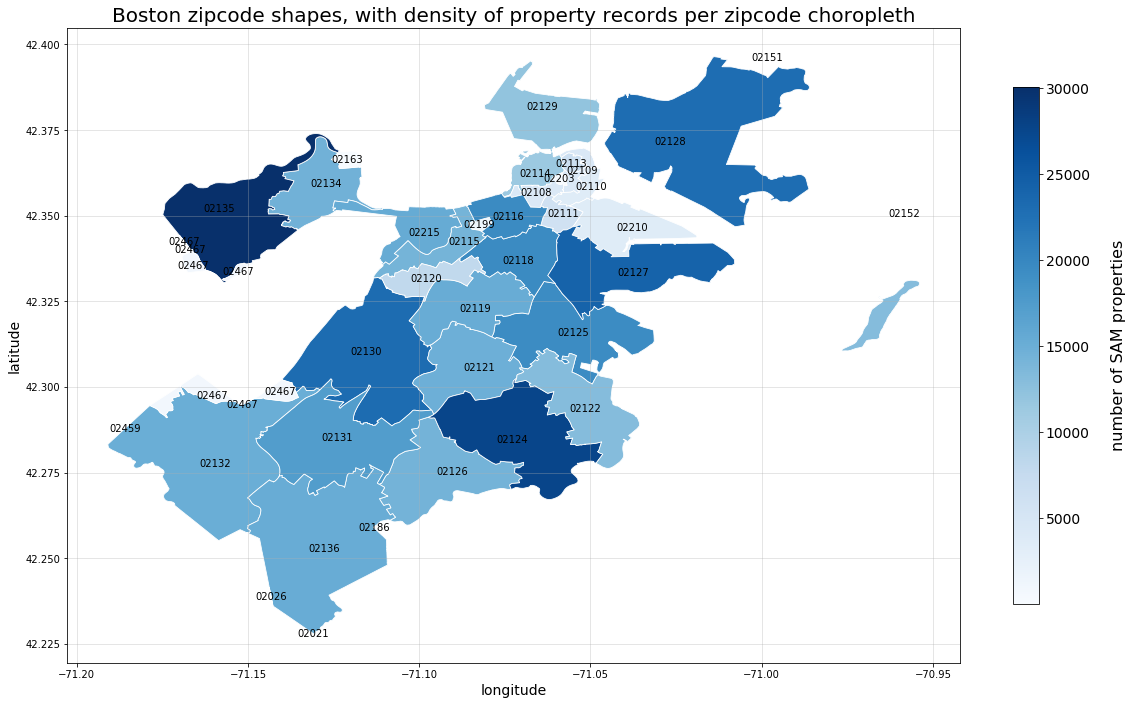

In [16]:
# Now to add a colorbar for better interpretability of our choropleth plot

savefig = False

variable = 'properties'

# set min and max variable values for use in plotting our colorbar
vmin = gdf_zip_prop[variable].describe()['min']
vmax = gdf_zip_prop[variable].describe()['max']

fig, ax = plt.subplots(figsize=(16,10))

plt.title(
    'Boston zipcode shapes, with density of property records per zipcode choropleth',
    fontsize=20
)

# NOTE: null values must be dropped from our df (as is shown below).
#       Otherwise, the choropleth does not provide any gradation in color
gdf_zip_prop.dropna(subset=[variable]).plot(
    column=variable,
    cmap='Blues',
    linewidth=0.8,
    ax=ax,
    edgecolor='white'
)

# here we use the geopandas dataframe object's built-in iterrows() method
# to turn gdf_zipshapes into a generator object for iteration
for idx, row in gdf_zipshapes.iterrows():
    plt.annotate(
        s=row['ZIP5'],
        xy=row['coords'],
        horizontalalignment='center',
        verticalalignment='center'
    )
    
# here we create a colorbar legend
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))

# ...then we add the colorbar to the figure
cbar = fig.colorbar(sm, ax=ax, shrink=.8, fraction=0.1)

# ...and finally we format the colorbar for readability
cbar.set_label(label='\nnumber of SAM properties', fontsize=16)
cbar.ax.tick_params(labelsize=14)

plt.xlabel('longitude', fontsize=14)
plt.ylabel('latitude', fontsize=14)
plt.grid(":", alpha=0.4)
plt.tight_layout()

# save sample choropleth for showing in README.md
if savefig:
    plt.savefig(os.path.join(FIGURES_ROOT, 'sample-choropleth.png'))
plt.show();

## 5. Match coordinates in one dataframe to corresponding shapes in a separate shapefile

Below are four (4) basic steps that allow us to match coordinates from a pandas.DataFrame object to corresponding polygons in a geopands.GeoDataFrame shapefile:

**STEP 1: Prior to matching coordinates, we first need to convert those coordinates to a geometry format recognized by GeoPandas.**

To do that we can use Shapely's `Point` method, imported from `shapely.geometry` at the start of this notebook.

There are TWO SIMPLE APPROACHES for converting an array of latitudes and longitudes to corresponding Point geometries.

- **The FIRST approach is to simple iterate through longitude and latitude records using a list comprehension.**

In [17]:
# PLEASE NOTE THAT COORDINATES MUST BE FED IN (LONGITUDE, LATITUDE), not the other way around
points_list = [Point(coord[1], coord[0]) for coord in df_sam[['X', 'Y']].values]

# The first 5 point objects in the points list look like
for points in points_list[:5]:
    print(points)

POINT (42.3439486679 -71.1413026168)
POINT (42.3439486679 -71.1413026168)
POINT (42.3439486679 -71.1413026168)
POINT (42.3439486679 -71.1413026168)
POINT (42.3439486679 -71.1413026168)


- **The SECOND (and MORE EFFICIENT) approach is to generate a GeoPandas GeoSeries wherein you use Python's `map()` method to generate the points.**

In [18]:
# PLEASE NOTE THAT COORDINATES MUST BE FED IN (LONGITUDE, LATITUDE), not the other way around
gs_points = gpd.GeoSeries(map(Point, zip(df_sam['X'].values, df_sam['Y'].values)))

# The head of the resulting GeoSeries now looks like
gs_points.head()

0    POINT (-71.1413026168 42.3439486679)
1    POINT (-71.1413026168 42.3439486679)
2    POINT (-71.1413026168 42.3439486679)
3    POINT (-71.1413026168 42.3439486679)
4    POINT (-71.1413026168 42.3439486679)
dtype: object

<br>

**STEP 2: Now, using our points GeoSeries, we can create a new GeoPandas dataframe for executing a "spatial join" for matching each point to a corresponding zipcode polygon**

- For GeoPandas `sjoin()` documentation, please see: http://geopandas.org/mergingdata.html#spatial-joins

In [19]:
# A good first step, is to reset the index of your pandas dataframe
# to prevent joining errors later on. If you have a dataframe with missing indices
# such as you might have if you've subsetted the data in any way, resetting your index
# will help to prevent some otherwise, very difficult to diagnose joining errors
df_sam = df_sam.reset_index(drop=True)

In [20]:
# define our crs parameter for our coordinate reference system
crs = {'init': 'epsg:4326'}

# create a new geodataframe using df_sam as the base, define crs, and add in our point
# geometries. 
#   NOTE: this exact same step can be done with `points_list` as well, you
#         just need to pass that list in as our `geometry` parameter instead of `gs_points`
gdf_sam = gpd.GeoDataFrame(df_sam, crs=crs, geometry=gs_points)

# Note the conversion of df_sam to a GeoDataFrame object type and the addition
# of the new "geometry" column appended to our original dataframe
print(type(gdf_sam))
print()
print(gdf_sam.columns)
gdf_sam['geometry'].head()

<class 'geopandas.geodataframe.GeoDataFrame'>

Index(['X', 'Y', 'SAM_ADDRESS_ID', 'RELATIONSHIP_TYPE', 'BUILDING_ID',
       'FULL_ADDRESS', 'STREET_NUMBER', 'IS_RANGE', 'RANGE_FROM', 'RANGE_TO',
       'UNIT', 'FULL_STREET_NAME', 'STREET_ID', 'STREET_PREFIX', 'STREET_BODY',
       'STREET_SUFFIX_ABBR', 'STREET_FULL_SUFFIX', 'STREET_SUFFIX_DIR',
       'STREET_NUMBER_SORT', 'MAILING_NEIGHBORHOOD', 'ZIP_CODE', 'X_COORD',
       'Y_COORD', 'SAM_STREET_ID', 'WARD', 'PRECINCT_WARD', 'PARCEL',
       'geometry'],
      dtype='object')


0    POINT (-71.1413026168 42.3439486679)
1    POINT (-71.1413026168 42.3439486679)
2    POINT (-71.1413026168 42.3439486679)
3    POINT (-71.1413026168 42.3439486679)
4    POINT (-71.1413026168 42.3439486679)
Name: geometry, dtype: object

<br>

**STEP 3: Finally, we can perform our spatial join between the two GeoDataFrames to match each Point to its corresponding zipcode polygon**

In [21]:
%%time

# First, we want to make certain we have a matching crs assigned to our new 
# GeoDataFrame (only do this if you know that both GeoFrames are using the
# same coordinate reference systems)
gdf_sam.crs = gdf_zipshapes.crs

# Then join our two GeoDataFrames
gdf_sam = gpd.sjoin(gdf_sam, gdf_zipshapes, how='left',op="within")

# and note the matched and appended zipcode shape data associated with each record
print(gdf_sam.columns)
print()
gdf_sam[
    ['SAM_ADDRESS_ID', 'geometry', 'index_right', 'OBJECTID', 'ZIP5', 'ShapeSTAre', 'ShapeSTLen']
].head()

Index(['X', 'Y', 'SAM_ADDRESS_ID', 'RELATIONSHIP_TYPE', 'BUILDING_ID',
       'FULL_ADDRESS', 'STREET_NUMBER', 'IS_RANGE', 'RANGE_FROM', 'RANGE_TO',
       'UNIT', 'FULL_STREET_NAME', 'STREET_ID', 'STREET_PREFIX', 'STREET_BODY',
       'STREET_SUFFIX_ABBR', 'STREET_FULL_SUFFIX', 'STREET_SUFFIX_DIR',
       'STREET_NUMBER_SORT', 'MAILING_NEIGHBORHOOD', 'ZIP_CODE', 'X_COORD',
       'Y_COORD', 'SAM_STREET_ID', 'WARD', 'PRECINCT_WARD', 'PARCEL',
       'geometry', 'index_right', 'OBJECTID', 'ZIP5', 'ShapeSTAre',
       'ShapeSTLen', 'coords'],
      dtype='object')

CPU times: user 15.1 s, sys: 1.22 s, total: 16.3 s
Wall time: 10.8 s


,SAM_ADDRESS_ID,geometry,index_right,OBJECTID,ZIP5,ShapeSTAre,ShapeSTLen
0,2530,POINT (-71.1413026168 42.3439486679),13.0,14.0,02135,7.862083e+07,61170.630938
1,2531,POINT (-71.1413026168 42.3439486679),13.0,14.0,02135,7.862083e+07,61170.630938
2,2532,POINT (-71.1413026168 42.3439486679),13.0,14.0,02135,7.862083e+07,61170.630938
3,2533,POINT (-71.1413026168 42.3439486679),13.0,14.0,02135,7.862083e+07,61170.630938
4,2534,POINT (-71.1413026168 42.3439486679),13.0,14.0,02135,7.862083e+07,61170.630938


<br>

**STEP 4: Now, your shapefile polygon data related to each point record can be appended back onto your original DataFrame.**

In [22]:
# identify which columns you wish to append
append_colnames = ['index_right', 'OBJECTID', 'ZIP5', 'ShapeSTAre', 'ShapeSTLen'] 

# copy those columns over from the GeoDataFrame to the pandas.DataFrame
df_sam[append_colnames] = gdf_sam[append_colnames].copy()

# review the resulting pandas.DataFrame and we're done!
print(df_sam.info())
print()
df_sam.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398702 entries, 0 to 398701
Data columns (total 33 columns):
X                       398702 non-null float64
Y                       398702 non-null float64
SAM_ADDRESS_ID          398702 non-null object
RELATIONSHIP_TYPE       398702 non-null object
BUILDING_ID             398702 non-null object
FULL_ADDRESS            398702 non-null object
STREET_NUMBER           398702 non-null object
IS_RANGE                398702 non-null object
RANGE_FROM              26175 non-null object
RANGE_TO                26175 non-null object
UNIT                    270100 non-null object
FULL_STREET_NAME        398702 non-null object
STREET_ID               398702 non-null object
STREET_PREFIX           398702 non-null object
STREET_BODY             398702 non-null object
STREET_SUFFIX_ABBR      394519 non-null object
STREET_FULL_SUFFIX      394519 non-null object
STREET_SUFFIX_DIR       398702 non-null object
STREET_NUMBER_SORT      398702 non-null obj

,X,Y,SAM_ADDRESS_ID,RELATIONSHIP_TYPE,BUILDING_ID,FULL_ADDRESS,STREET_NUMBER,IS_RANGE,RANGE_FROM,RANGE_TO,...,SAM_STREET_ID,WARD,PRECINCT_WARD,PARCEL,geometry,index_right,OBJECTID,ZIP5,ShapeSTAre,ShapeSTLen
0,-71.141303,42.343949,2530,2,174339,309 Allston St #309-9,309,0,NaN,NaN,...,88,21,2110,2101724000,POINT (-71.1413026168 42.3439486679),13.0,14.0,02135,7.862083e+07,61170.630938
1,-71.141303,42.343949,2531,2,174339,309 Allston St #309-10,309,0,NaN,NaN,...,88,21,2110,2101724000,POINT (-71.1413026168 42.3439486679),13.0,14.0,02135,7.862083e+07,61170.630938
2,-71.141303,42.343949,2532,2,174339,309 Allston St #309-11,309,0,NaN,NaN,...,88,21,2110,2101724000,POINT (-71.1413026168 42.3439486679),13.0,14.0,02135,7.862083e+07,61170.630938
3,-71.141303,42.343949,2533,2,174339,309 Allston St #309-12,309,0,NaN,NaN,...,88,21,2110,2101724000,POINT (-71.1413026168 42.3439486679),13.0,14.0,02135,7.862083e+07,61170.630938
4,-71.141303,42.343949,2534,2,174339,309 Allston St #309-14,309,0,NaN,NaN,...,88,21,2110,2101724000,POINT (-71.1413026168 42.3439486679),13.0,14.0,02135,7.862083e+07,61170.630938


In [23]:
# Note, that it appears one SAM record's coordinates did not fall within any
# of the corresponding zipcode polygons.

# This may warrant further investigation, but chances are it was either a faulty
# coordinate to begin with, or this zip area, represented as only a borderline as
# can be seen in the shapefile plots in part 1 of this tutorial, is improperly
# represented in the shapefile
print(gdf_sam.loc[gdf_sam['ZIP5'].isnull()]['ZIP_CODE'])

57865    02467
Name: ZIP_CODE, dtype: object


## 6. Find the minimum and maximum coordinate bounds to each polygon in a shapefile 

It is possible to identify the min and max bounds of each polygon in a shapefile by using the geopanda's built in `bounds` method.

This is particularly useful to do when you wish plot only one polygon, for which you can use these bounds to set matplotlib's xlim and ylim values.

In [24]:
# create dataframe containing x and y limits for each zipcode shape
df_zipbounds = pd.DataFrame(gdf_zipshapes['geometry'].bounds.set_index(gdf_zipshapes['ZIP5']))

df_zipbounds.head()

,minx,miny,maxx,maxy
ZIP5,,,,
02134,-71.144158,42.345826,-71.110634,42.373052
02125,-71.078824,42.300831,-71.031368,42.330800
02110,-71.061213,42.352740,-71.045859,42.364184
02118,-71.088246,42.326265,-71.059041,42.347522
02126,-71.111623,42.259624,-71.069495,42.291130
